# Estimates

In [471]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels.iv import IV2SLS
from patsy import dmatrix, build_design_matrices

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import parallel_backend

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [342]:
panel_dataset = pd.read_csv('data/panel_dataset')
panel_dataset = panel_dataset.set_index(['person', 'day'])
panel_dataset = panel_dataset.drop(columns='Unnamed: 0')
panel_dataset['income'] = panel_dataset.income / 1000
panel_dataset['became_member_on'] = panel_dataset.became_member_on / 365.25
day_one = pd.read_csv('data/day_one_dataset')
day_one = day_one.set_index('person')

In [343]:
panel_dataset.head()

offered_0b1e1539f2cc45b7b9fa7c272da2e1d7  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_2298d6c36e964ae4a3e7e9706d1fb8c2  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_2906b810c7d4411798c6938adc9daaa5  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_3f207df678b143eea3cee63160fa8bed  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_4d5c57ea9a6940dd891ad53e9dbe8da0  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_5a8bc65990b245e5a138643cd4eb9837  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_9b98b8c7a33c4b65b9aebfe6a799e6d9  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

             

In [344]:
# person effects
y = panel_dataset['revenue']
X = panel_dataset[['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_3f207df678b143eea3cee63160fa8bed',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_5a8bc65990b245e5a138643cd4eb9837',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']]
model = PanelOLS(y, X, entity_effects=True, time_effects=False)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/fe_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

Dep. Variable:,revenue,R-squared:,0.0014
Estimator:,PanelOLS,R-squared (Between):,0.3019
No. Observations:,510000,R-squared (Within):,0.0014
Date:,"Tue, Jul 30 2019",R-squared (Overall):,0.0219
Time:,11:16:54,Log-likelihood,-2.313e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,69.432
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(10,492990)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,67.173


In [345]:
# person effects with time dummies
df = panel_dataset.reset_index()
df['time'] = df.day
df = df.set_index(['person', 'day'])

formula = 'revenue ~ ' + \
           'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
           'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
           'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
           'offered_3f207df678b143eea3cee63160fa8bed + ' + \
           'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
           'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
           'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
           'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
           'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
           'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
           'C(time) + EntityEffects'
                  
model = PanelOLS.from_formula(formula, df)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/fe_time_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

Dep. Variable:,revenue,R-squared:,0.0026
Estimator:,PanelOLS,R-squared (Between):,0.0061
No. Observations:,510000,R-squared (Within):,0.0026
Date:,"Tue, Jul 30 2019",R-squared (Overall):,0.0028
Time:,11:17:03,Log-likelihood,-2.313e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,32.812
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(39,492961)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,1.629e+04


In [346]:
# no fixed effects yes time dummies
formula = 'revenue ~ ' + \
           'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
           'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
           'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
           'offered_3f207df678b143eea3cee63160fa8bed + ' + \
           'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
           'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
           'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
           'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
           'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
           'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
           'TimeEffects + 1'
                  
model = PanelOLS.from_formula(formula, panel_dataset)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/time_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

Dep. Variable:,revenue,R-squared:,0.0012
Estimator:,PanelOLS,R-squared (Between):,0.0066
No. Observations:,510000,R-squared (Within):,0.0013
Date:,"Tue, Jul 30 2019",R-squared (Overall):,0.0015
Time:,11:17:06,Log-likelihood,-2.325e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,61.325
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(10,509960)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,77.027


In [347]:
# no effects or covariates
y = panel_dataset['revenue']
X = panel_dataset[['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                   'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
                   'offered_2906b810c7d4411798c6938adc9daaa5',
                   'offered_3f207df678b143eea3cee63160fa8bed',
                   'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
                   'offered_5a8bc65990b245e5a138643cd4eb9837',
                   'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                   'offered_ae264e3637204a6fb9bb56bc8210ddfd',
                   'offered_f19421c1d4aa40978ebb69ca19b0e20d',
                   'offered_fafdcd668e3743c1bb461111dcafc2a4']]
X = sm.add_constant(X)
model = PanelOLS(y, X, entity_effects=False, time_effects=False)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/simple_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,revenue,R-squared:,0.0016
Estimator:,PanelOLS,R-squared (Between):,0.0059
No. Observations:,510000,R-squared (Within):,0.0014
Date:,"Tue, Jul 30 2019",R-squared (Overall):,0.0016
Time:,11:17:08,Log-likelihood,-2.325e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,81.243
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(10,509989)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,123.40


In [348]:
# no effects, yes covariates
formula = 'revenue ~ ' + \
           'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
           'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
           'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
           'offered_3f207df678b143eea3cee63160fa8bed + ' + \
           'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
           'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
           'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
           'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
           'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
           'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
           'age + age**2 + age**3 + ' + \
           'became_member_on + became_member_on**2 + became_member_on**3 + ' + \
           'income + income**2 + income**3 + ' + \
           'gender_F + gender_O + 1'
                  
model = PanelOLS.from_formula(formula, panel_dataset)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/covariates_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\linearmodels\utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,revenue,R-squared:,0.0064
Estimator:,PanelOLS,R-squared (Between):,0.1101
No. Observations:,444750,R-squared (Within):,0.0015
Date:,"Tue, Jul 30 2019",R-squared (Overall):,0.0064
Time:,11:17:10,Log-likelihood,-2.055e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,189.51
Entities:,14825,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(15,444734)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,174.31


In [359]:
# ToT without person FE but with time dummies
df = panel_dataset.reset_index()
df = df[df['age'].notnull()]

y = df['revenue']
exog = df[['age', 'became_member_on', 'income', 'gender_F', 'gender_O', 'day']]
exog = pd.get_dummies(exog, columns=['day'], drop_first=True)
exog = sm.add_constant(exog)
endog = df[['viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                   'viewed_2298d6c36e964ae4a3e7e9706d1fb8c2',
                   'viewed_2906b810c7d4411798c6938adc9daaa5',
                   'viewed_3f207df678b143eea3cee63160fa8bed',
                   'viewed_4d5c57ea9a6940dd891ad53e9dbe8da0',
                   'viewed_5a8bc65990b245e5a138643cd4eb9837',
                   'viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                   'viewed_ae264e3637204a6fb9bb56bc8210ddfd',
                   'viewed_f19421c1d4aa40978ebb69ca19b0e20d',
                   'viewed_fafdcd668e3743c1bb461111dcafc2a4']]
instruments = df[['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                   'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
                   'offered_2906b810c7d4411798c6938adc9daaa5',
                   'offered_3f207df678b143eea3cee63160fa8bed',
                   'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
                   'offered_5a8bc65990b245e5a138643cd4eb9837',
                   'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                   'offered_ae264e3637204a6fb9bb56bc8210ddfd',
                   'offered_f19421c1d4aa40978ebb69ca19b0e20d',
                   'offered_fafdcd668e3743c1bb461111dcafc2a4']]
               
model = IV2SLS(y, exog, endog, instruments)
result = model.fit(cov_type='clustered', debiased=True, clusters=df.person)

with open('causal_results/tot_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                revenue   R-squared:                      0.0076
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0075
No. Observations:              444750   F-statistic:                    72.236
Date:                Tue, Jul 30 2019   P-value (F-stat)                0.0000
Time:                        11:22:12   Distribution:             F(44,444705)
Cov. Estimator:             clustered                                         
                                                                              
                                            Parameter Estimates                                            
===========================================================================================================
                                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------------
const                                       22.930     1.5329     14.958     0.0000      19.925      25.934
age                                         0.0032     0.0024     1.3367     0.1813     -0.0015      0.0080
became_member_on                           -0.5464     0.0319    -17.154     0.0000     -0.6088     -0.4840
income                                      0.0634     0.0020     31.205     0.0000      0.0594      0.0674
gender_F                                    0.8057     0.0873     9.2269     0.0000      0.6346      0.9769
gender_O                                    0.5731     0.2444     2.3455     0.0190      0.0942      1.0521
day_2                                       0.0989     0.1957     0.5052     0.6134     -0.2848      0.4825
day_3                                       0.1729     0.1991     0.8684     0.3852     -0.2174      0.5633
day_4                                      -0.1036     0.1868    -0.5546     0.5792     -0.4698      0.2626
day_5                                      -0.0270     0.2082    -0.1297     0.8968     -0.4350      0.3810
day_6                                      -0.2146     0.2013    -1.0663     0.2863     -0.6092      0.1799
day_7                                      -0.5799     0.1908    -3.0401     0.0024     -0.9538     -0.2060
day_8                                      -0.3117     0.2216    -1.4068     0.1595     -0.7460      0.1226
day_9                                       0.1011     0.2076     0.4872     0.6261     -0.3057      0.5079
day_10                                      0.2213     0.2205     1.0035     0.3156     -0.2109      0.6535
day_11                                     -0.2108     0.2158    -0.9767     0.3287     -0.6337      0.2122
day_12                                     -0.5713     0.2042    -2.7982     0.0051     -0.9715     -0.1712
day_13                                     -0.6299     0.2150    -2.9303     0.0034     -1.0513     -0.2086
day_14                                     -0.9820     0.1997    -4.9180     0.0000     -1.3734     -0.5907
day_15                                     -0.6136     0.2307    -2.6597     0.0078     -1.0658     -0.1614
day_16                                     -0.0618     0.2463    -0.2508     0.8020     -0.5444      0.4209
day_17                                     -0.2027     0.2032    -0.9976     0.3185     -0.6010      0.1955
day_18                                      1.4728     0.4113     3.5808     0.0003      0.6666      2.2789
day_19                                      1.1161     0.2804     3.9798     0.0001      0.5664      1.6657
day_20                                      0.7210     0.2553     2.8247     0.0047      0.2207      1.2213
day_21                                      0.3934     0.3052     1.2893     0.1973     -0.2047      0.

## Prediction with Cubic Spline Smoothing using L2 Regulation

### Prepare data pipeline

In [405]:
# Custom transform for natural spline basis
class NaturalSpline(BaseEstimator, TransformerMixin):

    def __init__(self, df=4):
        self.df = df
        self.spline = None

    def fit(self, X, y=None):
        self.spline = dmatrix('cr(x, df=self.df) - 1', {'x': X}).design_info
        return self

    def transform(self, X, y=None):
        mat = build_design_matrices([self.spline], {'x': X}, NA_action='raise', return_type='matrix')[0]
        return np.array(mat)

In [406]:
# machine learning pipline to scale variables, form univariate natural spline bases for continuous variables,
# form tensor product bases, and estimate logistic regression
# also make a pipline for global cubic polynomials
pipeline_spline = Pipeline([
    ('minmax', MinMaxScaler()),
    ('splines', ColumnTransformer(remainder='passthrough', transformers=[
        ('s1', NaturalSpline(), 10),
        ('s2', NaturalSpline(), 11),
        ('s3', NaturalSpline(), 12)
    ])),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=400))
])

pipeline_global = Pipeline([
    ('minmax', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=400))
])

### Predict Viewing

In [407]:
# prepare offer viewing data and split to train and test sets
df = day_one.dropna()
viewed = df.viewed.astype(int)
X = df.drop(columns=['viewed', 'completed'])
Xv_train, Xv_test, viewed_train, viewed_test = train_test_split(X, viewed, test_size=0.2, random_state=424)

In [408]:
# grid search through spline flexibility and regulation parameter
# fit model
cv_viewed = GridSearchCV(pipeline_spline, cv=10, n_jobs=3, verbose=1, scoring='neg_log_loss', param_grid={
    'splines__s1__df': [3, 4, 5, 6],
    'splines__s2__df': [3, 4, 5, 6],
    'splines__s3__df': [3, 4, 5, 6],
    'logit__C': np.linspace(0.1, 5, 50)
})
with parallel_backend('threading'):
    cv_viewed.fit(Xv_train, viewed_train)
cv_viewed.best_estimator_

Fitting 10 folds for each of 3200 candidates, totalling 32000 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   13.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 11.7min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 17.1min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 24.0min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 32.2min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 42.3min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 54.2min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 68.5min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 84.5min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 102.7min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('splines',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('s1', NaturalSpline(df=4),
                                                  10),
                                                 ('s2', NaturalSpline(df=3),
                                                  11),
                                                 ('s3', NaturalSpline(df=4),
                                                  12)],
                                   verbose=False)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=True, order='C')),
                ('logit',
                 LogisticRegression(C=3.1, clas

In [409]:
# review spline cross validation results
cv_viewed_res = pd.DataFrame(cv_viewed.cv_results_)
cv_viewed_res.to_csv('cross_validation_scores/cv_viewed_spline_results')
cv_viewed_res.sort_values('mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_splines__s1__df,param_splines__s2__df,param_splines__s3__df,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
63,1.141745,0.075092,0.060142,0.012328,0.1,6,6,6,"{'logit__C': 0.1, 'splines__s1__df': 6, 'splin...",-0.301279,...,-0.274066,-0.263991,-0.295625,-0.266921,-0.281888,-0.272009,-0.268169,-0.278250,0.011567,3200
62,1.073628,0.027983,0.046976,0.006785,0.1,6,6,5,"{'logit__C': 0.1, 'splines__s1__df': 6, 'splin...",-0.302134,...,-0.273452,-0.264328,-0.294505,-0.265298,-0.282014,-0.273118,-0.268482,-0.277912,0.011639,3199
59,1.080907,0.064253,0.051565,0.007726,0.1,6,5,6,"{'logit__C': 0.1, 'splines__s1__df': 6, 'splin...",-0.300329,...,-0.274329,-0.262808,-0.295475,-0.266237,-0.281870,-0.271255,-0.268137,-0.277591,0.011589,3198
58,1.055575,0.037862,0.048074,0.010099,0.1,6,5,5,"{'logit__C': 0.1, 'splines__s1__df': 6, 'splin...",-0.301134,...,-0.273923,-0.263062,-0.294307,-0.264600,-0.281921,-0.272328,-0.268450,-0.277283,0.011656,3197
47,1.070037,0.050951,0.041990,0.005773,0.1,5,6,6,"{'logit__C': 0.1, 'splines__s1__df': 5, 'splin...",-0.300455,...,-0.272432,-0.263442,-0.294370,-0.265640,-0.280824,-0.271472,-0.268481,-0.277230,0.011419,3196
61,1.079512,0.029177,0.041990,0.005736,0.1,6,6,4,"{'logit__C': 0.1, 'splines__s1__df': 6, 'splin...",-0.302233,...,-0.271371,-0.262054,-0.294508,-0.264264,-0.282525,-0.272490,-0.267635,-0.277000,0.012252,3195
46,1.071532,0.050029,0.043487,0.005591,0.1,5,6,5,"{'logit__C': 0.1, 'splines__s1__df': 5, 'splin...",-0.301393,...,-0.271745,-0.263825,-0.293353,-0.264127,-0.281049,-0.272595,-0.268871,-0.276987,0.011542,3194
60,1.014785,0.052949,0.038399,0.003432,0.1,6,6,3,"{'logit__C': 0.1, 'splines__s1__df': 6, 'splin...",-0.301418,...,-0.269864,-0.263224,-0.293633,-0.263867,-0.283033,-0.273287,-0.267743,-0.276987,0.011926,3193
43,1.085296,0.054135,0.051963,0.008745,0.1,5,5,6,"{'logit__C': 0.1, 'splines__s1__df': 5, 'splin...",-0.299566,...,-0.272625,-0.262284,-0.294192,-0.265088,-0.280733,-0.270766,-0.268468,-0.276600,0.011439,3192
31,1.065150,0.059879,0.046977,0.009370,0.1,4,6,6,"{'logit__C': 0.1, 'splines__s1__df': 4, 'splin...",-0.300498,...,-0.271921,-0.261426,-0.294634,-0.263856,-0.280003,-0.271198,-0.267948,-0.276526,0.011945,3191


In [410]:
# grid search through regulation parameter with global polynomials
# fit model
cv_viewed_global = GridSearchCV(pipeline_global, cv=10, n_jobs=3, verbose=1, scoring='neg_log_loss', param_grid={
    'logit__C': np.linspace(0.1, 5, 50)
})
with parallel_backend('threading'):
    cv_viewed_global.fit(Xv_train, viewed_train)
cv_viewed_global.best_estimator_

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  5.1min
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('poly',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logit',
                 LogisticRegression(C=3.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=400,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [411]:
# review global polynomial cross validation results
cv_viewed_global_res = pd.DataFrame(cv_viewed_global.cv_results_)
cv_viewed_global_res.to_csv('cross_validation_scores/cv_viewed_global_results')
cv_viewed_global_res.sort_values('param_logit__C')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.011419,0.056792,0.093153,0.012928,0.1,{'logit__C': 0.1},-0.292237,-0.266158,-0.267643,-0.255129,-0.249873,-0.282574,-0.252674,-0.276815,-0.263380,-0.259531,-0.266604,0.012977,50
1,2.456329,0.123758,0.078194,0.006737,0.2,{'logit__C': 0.2},-0.289204,-0.259356,-0.260469,-0.248947,-0.242613,-0.277778,-0.246663,-0.271671,-0.257114,-0.252906,-0.260675,0.014010,49
2,2.943127,0.121167,0.084079,0.011638,0.3,{'logit__C': 0.30000000000000004},-0.288741,-0.256762,-0.257626,-0.246847,-0.239929,-0.276317,-0.244600,-0.269911,-0.255011,-0.250470,-0.258624,0.014550,48
3,3.228463,0.130498,0.081285,0.007154,0.4,{'logit__C': 0.4},-0.288778,-0.255340,-0.256044,-0.245838,-0.238510,-0.275669,-0.243588,-0.269025,-0.254008,-0.249201,-0.257603,0.014899,47
4,3.648938,0.171925,0.079989,0.004389,0.5,{'logit__C': 0.5},-0.288954,-0.254418,-0.255003,-0.245264,-0.237629,-0.275309,-0.243011,-0.268494,-0.253449,-0.248447,-0.257000,0.015146,46
5,3.889296,0.130435,0.079193,0.009208,0.6,{'logit__C': 0.6},-0.289169,-0.253760,-0.254249,-0.244916,-0.237017,-0.275084,-0.242642,-0.268146,-0.253101,-0.247936,-0.256605,0.015337,45
6,4.138629,0.164451,0.084180,0.006738,0.7,{'logit__C': 0.7000000000000001},-0.289394,-0.253254,-0.253673,-0.244689,-0.236566,-0.274941,-0.242398,-0.267900,-0.252867,-0.247580,-0.256329,0.015490,44
7,4.322538,0.144364,0.081087,0.007966,0.8,{'logit__C': 0.8},-0.289611,-0.252862,-0.253220,-0.244546,-0.236212,-0.274828,-0.242233,-0.267717,-0.252715,-0.247316,-0.256128,0.015614,43
8,4.563394,0.151390,0.084678,0.010057,0.9,{'logit__C': 0.9},-0.289828,-0.252534,-0.252839,-0.244447,-0.235935,-0.274754,-0.242118,-0.267582,-0.252599,-0.247107,-0.255977,0.015724,42
9,4.953450,0.152346,0.082882,0.008914,1,{'logit__C': 1.0},-0.290024,-0.252265,-0.252516,-0.244385,-0.235705,-0.274699,-0.242039,-0.267474,-0.252515,-0.246941,-0.255859,0.015816,41


### Predict Completion

In [412]:
# to predict completions, drop informational offer columns and recipients
df = day_one[day_one['offered_3f207df678b143eea3cee63160fa8bed']==0]
df = df[df['offered_5a8bc65990b245e5a138643cd4eb9837']==0]
df = df.drop(columns=['offered_3f207df678b143eea3cee63160fa8bed', 'offered_5a8bc65990b245e5a138643cd4eb9837'])
# drop na and create data collections
df = df.dropna()
completed = df.completed
X = df.drop(columns=['viewed', 'completed'])
# split train and test data sets
Xc_train, Xc_test, completed_train, completed_test = train_test_split(X, completed, test_size=0.2, random_state=422)

In [413]:
# grid search through spline flexibility and regulation parameter
# fit model
cv_completed = GridSearchCV(pipeline_spline, cv=10, n_jobs=3, verbose=1, scoring='neg_log_loss', param_grid={
    'splines__s1__df': [3, 4, 5, 6],
    'splines__s2__df': [3, 4, 5, 6],
    'splines__s3__df': [3, 4, 5, 6],
    'logit__C': np.linspace(0.1, 5, 50)
})
with parallel_backend('threading'):
    cv_completed.fit(Xc_train, completed_train)
cv_completed.best_estimator_

Fitting 10 folds for each of 3200 candidates, totalling 32000 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   11.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   56.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 11.6min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 17.2min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 24.3min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 33.0min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 43.6min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 56.1min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 70.9min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 87.8min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 107.1min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=3)]: Done 24194 tasks      | elapsed: 364.2min
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\kri

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('splines',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('s1', NaturalSpline(df=3),
                                                  10),
                                                 ('s2', NaturalSpline(df=6),
                                                  11),
                                                 ('s3', NaturalSpline(df=5),
                                                  12)],
                                   verbose=False)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=True, order='C')),
                ('logit',
                 LogisticRegression(C=5.0, clas

In [414]:
# review spline cross validation results
cv_completed_res = pd.DataFrame(cv_completed.cv_results_)
cv_completed_res.to_csv('cross_validation_scores/cv_completed_spline_results')
cv_completed_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_splines__s1__df,param_splines__s2__df,param_splines__s3__df,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.720765,0.031733,0.027029,0.004874,0.1,3,3,3,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435629,-0.435737,-0.435024,0.012427,3138
1,0.752287,0.043953,0.024835,0.004265,0.1,3,3,4,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435632,-0.435737,-0.435024,0.012427,3144
2,0.780910,0.043022,0.023638,0.002404,0.1,3,3,5,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435632,-0.435737,-0.435024,0.012427,3147
3,0.818709,0.044423,0.032614,0.007891,0.1,3,3,6,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435632,-0.435737,-0.435024,0.012427,3146
4,0.765452,0.030490,0.025533,0.005680,0.1,3,4,3,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435629,-0.435737,-0.435024,0.012427,3141
5,0.787393,0.034664,0.028126,0.004083,0.1,3,4,4,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435632,-0.435737,-0.435024,0.012427,3151
6,0.814619,0.026964,0.029623,0.006371,0.1,3,4,5,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435629,-0.435737,-0.435024,0.012427,3137
7,0.869972,0.053756,0.029822,0.003322,0.1,3,4,6,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435629,-0.435737,-0.435024,0.012427,3142
8,0.788190,0.042007,0.025136,0.002778,0.1,3,5,3,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435631,-0.435737,-0.435024,0.012427,3143
9,0.793277,0.036389,0.031817,0.004600,0.1,3,5,4,"{'logit__C': 0.1, 'splines__s1__df': 3, 'splin...",-0.442504,...,-0.446203,-0.426825,-0.453008,-0.443884,-0.425509,-0.435632,-0.435737,-0.435024,0.012427,3148


In [415]:
# grid search through regulation parameter with global polynomials
# fit model
cv_completed_global = GridSearchCV(pipeline_global, cv=10, n_jobs=3, verbose=1, scoring='neg_log_loss', param_grid={
    'logit__C': np.linspace(0.1, 5, 50)
})
with parallel_backend('threading'):
    cv_completed_global.fit(Xc_train, completed_train)
cv_completed_global.best_estimator_

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   29.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.4min
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\skle

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('poly',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logit',
                 LogisticRegression(C=1.3000000000000003, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=400, multi_class='warn',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [416]:
# review global polynomial cross validation results
cv_completed_global_res = pd.DataFrame(cv_completed_global.cv_results_)
cv_completed_global_res.to_csv('cross_validation_scores/cv_completed_global_results')
cv_completed_global_res.sort_values('param_logit__C')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.356789,0.072295,0.068020,0.016153,0.1,{'logit__C': 0.1},-0.426873,-0.389992,-0.419119,-0.422101,-0.408675,-0.431813,-0.424067,-0.407482,-0.418735,-0.421673,-0.417051,0.011454,50
1,1.733361,0.099192,0.060840,0.005162,0.2,{'logit__C': 0.2},-0.421255,-0.384801,-0.415970,-0.413628,-0.403277,-0.427958,-0.418330,-0.401378,-0.412934,-0.416575,-0.411608,0.011611,49
2,1.990573,0.084965,0.053959,0.005508,0.3,{'logit__C': 0.30000000000000004},-0.419098,-0.382941,-0.415143,-0.410092,-0.401326,-0.427090,-0.416206,-0.399125,-0.410980,-0.414865,-0.409684,0.011788,48
3,2.206297,0.089142,0.052065,0.004963,0.4,{'logit__C': 0.4},-0.417970,-0.382000,-0.414856,-0.408139,-0.400366,-0.426968,-0.415156,-0.397941,-0.410111,-0.414087,-0.408757,0.011954,47
4,2.459719,0.120271,0.050768,0.004049,0.5,{'logit__C': 0.5},-0.417283,-0.381438,-0.414747,-0.406924,-0.399817,-0.427091,-0.414572,-0.397222,-0.409673,-0.413674,-0.408242,0.012099,45
5,2.603334,0.130579,0.052363,0.003489,0.6,{'logit__C': 0.6},-0.416833,-0.381073,-0.414725,-0.406084,-0.399477,-0.427310,-0.414213,-0.396730,-0.409439,-0.413433,-0.407929,0.012227,31
6,2.750441,0.120489,0.052962,0.005323,0.7,{'logit__C': 0.7000000000000001},-0.416519,-0.380822,-0.414740,-0.405485,-0.399273,-0.427567,-0.413990,-0.396380,-0.409325,-0.413283,-0.407736,0.012338,22
7,2.911410,0.129725,0.052962,0.003322,0.8,{'logit__C': 0.8},-0.416290,-0.380636,-0.414765,-0.405038,-0.399139,-0.427839,-0.413841,-0.396110,-0.409271,-0.413205,-0.407611,0.012438,16
8,3.126437,0.121597,0.052262,0.005485,0.9,{'logit__C': 0.9},-0.416112,-0.380492,-0.414792,-0.404696,-0.399043,-0.428122,-0.413750,-0.395896,-0.409267,-0.413150,-0.407529,0.012532,12
9,3.259579,0.108725,0.051565,0.005517,1,{'logit__C': 1.0},-0.415979,-0.380380,-0.414819,-0.404428,-0.398988,-0.428388,-0.413696,-0.395725,-0.409292,-0.413127,-0.407480,0.012615,8


### I am using the “one standard error” rule. This means I select the most parsimonious model with mean cross-validation error that lies within one standard error of the best-performing model. 

### For offer viewing, I use

### For offer completion, I use 

### Review and Visualize Model Performance

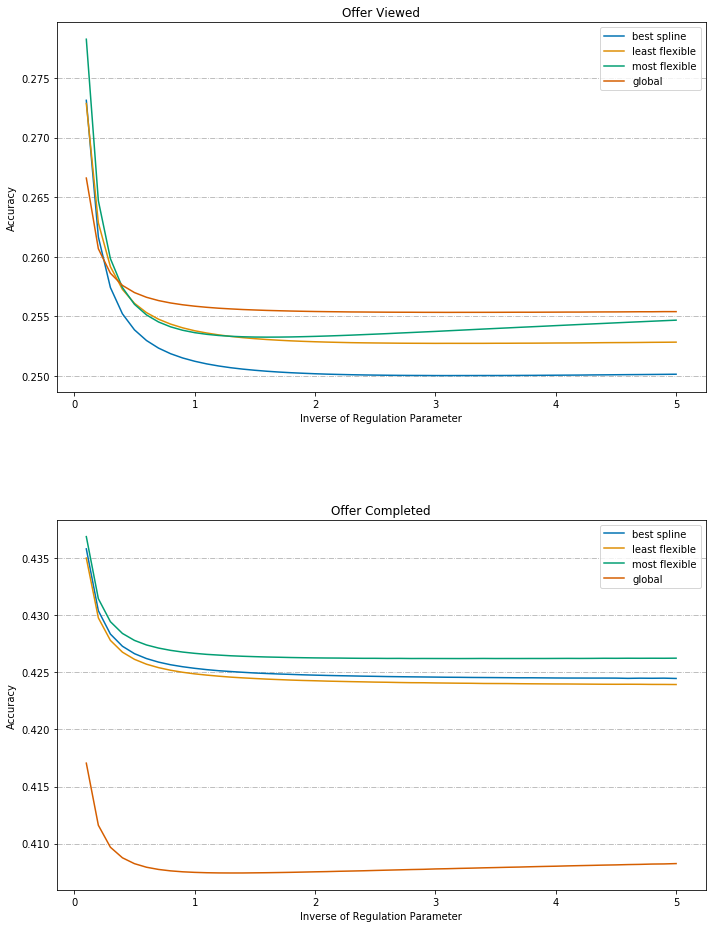

<Figure size 720x936 with 0 Axes>

In [434]:
vval_best = cv_viewed_res[(cv_viewed_res.param_splines__s1__df == 4) & 
                            (cv_viewed_res.param_splines__s2__df == 3) & 
                            (cv_viewed_res.param_splines__s3__df == 4)]
vval_least_flex = cv_viewed_res[(cv_viewed_res.param_splines__s1__df == 3) & 
                            (cv_viewed_res.param_splines__s2__df == 3) & 
                            (cv_viewed_res.param_splines__s3__df == 3)]
vval_most_flex = cv_viewed_res[(cv_viewed_res.param_splines__s1__df == 6) & 
                            (cv_viewed_res.param_splines__s2__df == 6) & 
                            (cv_viewed_res.param_splines__s3__df == 6)]
vval_global = cv_viewed_global_res
cval_best = cv_completed_res[(cv_completed_res.param_splines__s1__df == 4) & 
                            (cv_completed_res.param_splines__s2__df == 6) & 
                            (cv_completed_res.param_splines__s3__df == 5)]
cval_least_flex = cv_completed_res[(cv_completed_res.param_splines__s1__df == 3) & 
                            (cv_completed_res.param_splines__s2__df == 3) & 
                            (cv_completed_res.param_splines__s3__df == 3)]
cval_most_flex = cv_completed_res[(cv_completed_res.param_splines__s1__df == 6) & 
                            (cv_completed_res.param_splines__s2__df == 6) & 
                            (cv_completed_res.param_splines__s3__df == 6)]
cval_global = cv_completed_global_res

sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (10, 13)
fig = plt.Figure()

ax1 = plt.subplot(2, 1, 1)
sns.lineplot(vval_best.param_logit__C, -1 * vval_best.mean_test_score, ax=ax1, label='best spline')
sns.lineplot(vval_least_flex.param_logit__C, -1 * vval_least_flex.mean_test_score, ax=ax1, label='least flexible')
sns.lineplot(vval_most_flex.param_logit__C, -1 * vval_most_flex.mean_test_score, ax=ax1, label='most flexible')
sns.lineplot(vval_global.param_logit__C, -1 * vval_global.mean_test_score, ax=ax1, label='global')

plt.title('Offer Viewed', fontsize=12)
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Inverse of Regulation Parameter\n\n\n\n\n\n', fontsize=10)
plt.legend(loc=1)
plt.grid(axis='y', linestyle='-.', zorder=1)

ax2 = plt.subplot(2, 1, 2)
sns.lineplot(cval_best.param_logit__C, -1 * cval_best.mean_test_score, ax=ax2, label='best spline')
sns.lineplot(cval_least_flex.param_logit__C, -1 * cval_least_flex.mean_test_score, ax=ax2, label='least flexible')
sns.lineplot(cval_most_flex.param_logit__C, -1 * cval_most_flex.mean_test_score, ax=ax2, label='most flexible')
sns.lineplot(cval_global.param_logit__C, -1 * cval_global.mean_test_score, ax=ax2, label='global')
plt.title('Offer Completed', fontsize=12)
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Inverse of Regulation Parameter', fontsize=10)
plt.legend(loc=1)
plt.grid(axis='y', linestyle='-.', zorder=1)

plt.tight_layout()
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('graphs/cv.png', dpi=400, bbox_inches='tight')

In [491]:
# estimate selected models on the training data
# For offer viewing, I use the model with 3 degrees of freedom for each spline basis 
# and an inverse regulation parameter of 0.005
# For offer completion, I use the global cubic polynomial model with regulation parameter of 0.025

view_model = Pipeline([
    ('minmax', MinMaxScaler()),
    ('splines', ColumnTransformer(remainder='passthrough', transformers=[
        ('s1', NaturalSpline(df=4), 10),
        ('s2', NaturalSpline(df=3), 11),
        ('s3', NaturalSpline(df=4), 12)
    ])),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=400, C=3.1))
]).fit(Xv_train, viewed_train)

completion_model = Pipeline([
    ('minmax', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=400, C=1.3))
]).fit(Xc_train, completed_train)

In [492]:
# get train error for selected models
vtrain_predictions = view_model.predict(Xv_train)
vtrain_error = accuracy_score(viewed_train, vtrain_predictions)
ctrain_predictions = completion_model.predict(Xc_train)
ctrain_error = accuracy_score(completed_train, ctrain_predictions)
print(f'View model train accuracy: {vtrain_error}')
print(f'Completion model train accuracy: {ctrain_error}')

View model train accuracy: 0.8827150084317033
Completion model train accuracy: 0.7928543151227236


In [493]:
# get test error for selected models
vt_predictions = view_model.predict(Xv_test)
vt_error = accuracy_score(viewed_test, vt_predictions)
ct_predictions = completion_model.predict(Xc_test)
ct_error = accuracy_score(completed_test, ct_predictions)
print(f'View model test accuracy: {vt_error}')
print(f'Completion model test accuracy: {ct_error}')

View model test accuracy: 0.8789207419898819
Completion model test accuracy: 0.7676167854315122


In [494]:
# get test error for selected model by offer for viewing
dodf = day_one.dropna()
for offer in ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_3f207df678b143eea3cee63160fa8bed',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_5a8bc65990b245e5a138643cd4eb9837',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']:
    idx = dodf[dodf[offer]==1].index
    dfX = Xv_test.loc[Xv_test.index.isin(idx),:]
    dfy = viewed_test[viewed_test.index.isin(idx)]
    df_predictions = view_model.predict(dfX)
    print(f'Sample size: {df_predictions.shape[0]}')
    df_error = accuracy_score(dfy, df_predictions)
    print(f'View model test accuracy for offer {offer}: {df_error}')
    print(f'View model precision score for offer {offer}: {recall_score(dfy, df_predictions)}')
    print(f'View model recall score for offer {offer}: {precision_score(dfy, df_predictions)}')
    print()

Sample size: 227
View model test accuracy for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.6519823788546255
View model precision score for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.1411764705882353
View model recall score for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.6666666666666666

Sample size: 215
View model test accuracy for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 0.9906976744186047
View model precision score for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 1.0
View model recall score for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 0.9906976744186047

Sample size: 250
View model test accuracy for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.68
View model precision score for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.8206896551724138
View model recall score for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.6878612716763006

Sample size: 212
View model test accuracy for offer offered_3f207df678b143eea3cee63160fa8bed: 0.660377358490

In [495]:
# get test error for selected model by offer for completion
dodf = day_one.dropna()
for offer in ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']:
    idx = dodf[dodf[offer]==1].index
    dfX = Xc_test.loc[Xc_test.index.isin(idx),:]
    dfy = completed_test[completed_test.index.isin(idx)]
    df_predictions = completion_model.predict(dfX)
    print(f'Sample size: {df_predictions.shape[0]}')
    df_error = accuracy_score(dfy, df_predictions)
    print(f'Completion model test accuracy for offer {offer}: {df_error}')
    print(f'Completion model precision score for offer {offer}: {recall_score(dfy, df_predictions)}')
    print(f'Completion model recall score for offer {offer}: {precision_score(dfy, df_predictions)}')
    print()

Sample size: 215
Completion model test accuracy for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.6465116279069767
Completion model precision score for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.136986301369863
Completion model recall score for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.43478260869565216

Sample size: 215
Completion model test accuracy for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 0.7348837209302326
Completion model precision score for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 0.8888888888888888
Completion model recall score for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 0.757396449704142

Sample size: 235
Completion model test accuracy for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.6808510638297872
Completion model precision score for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.7
Completion model recall score for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.7165354330708661

Sample size: 208
Completion model test ac

### Explore and Visualize Predictive Effect Heterogeneity

In [496]:
max_age = int(day_one.dropna().age.max())
max_income = int(day_one.dropna().income.max())
print(f'max age in full sample is: {max_age}')
print(f'max income in full sample is: {max_income}')
print()
min_age = int(day_one.dropna().age.min())
min_income = int(day_one.dropna().income.min())
print(f'min age in full sample is: {min_age}')
print(f'min income in full sample is: {min_income}')

max age in full sample is: 101
max income in full sample is: 120000

min age in full sample is: 18
min income in full sample is: 30000


In [497]:
# create lists for re-use (I should have done this earlier, probably!)
offer_list = ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_3f207df678b143eea3cee63160fa8bed',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_5a8bc65990b245e5a138643cd4eb9837',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']
offer_listc = ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']
ages = list(range(18, 101))
incomes = list(range(30000, 121000, 1000))

In [498]:
# predict mean viewing probability by age for each offer
agev_proba = dict()
agev_mean_proba = dict()
for offer in offer_list:
    pseudo_Xt = Xv_test.copy()
    pseudo_Xt.loc[:, offer_list] = 0
    pseudo_Xt.loc[:, offer] = 1
    agev_mean_proba[offer] = list()
    for i in ages:
        pseudo_Xt.loc[:, 'age'] = i
        pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
        agev_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        agev_mean_proba[offer].append(mean_pseudo_pred)

In [499]:
# predict mean completion probability by age for each offer
agec_proba = dict()
agec_mean_proba = dict()
for offer in offer_listc:
    pseudo_Xt = Xc_test.copy()
    pseudo_Xt.loc[:, offer_listc] = 0
    pseudo_Xt.loc[:, offer] = 1
    agec_mean_proba[offer] = list()
    for i in ages:
        pseudo_Xt.loc[:, 'age'] = i
        pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
        agec_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        agec_mean_proba[offer].append(mean_pseudo_pred)

In [500]:
# predict mean viewing probability by income for each offer
incv_proba = dict()
incv_mean_proba = dict()
for offer in offer_list:
    pseudo_Xt = Xv_test.copy()
    pseudo_Xt.loc[:, offer_list] = 0
    pseudo_Xt.loc[:, offer] = 1
    incv_mean_proba[offer] = list()
    for i in incomes:
        pseudo_Xt.loc[:, 'income'] = i
        pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
        incv_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        incv_mean_proba[offer].append(mean_pseudo_pred)

In [501]:
# predict mean completion probability by income for each offer
incc_proba = dict()
incc_mean_proba = dict()
for offer in offer_listc:
    pseudo_Xt = Xc_test.copy()
    pseudo_Xt.loc[:, offer_listc] = 0
    pseudo_Xt.loc[:, offer] = 1
    incc_mean_proba[offer] = list()
    for i in incomes:
        pseudo_Xt.loc[:, 'income'] = i
        pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
        incc_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        incc_mean_proba[offer].append(mean_pseudo_pred)

In [502]:
# predict mean viewing probability by gender for each offer
genv_mean_proba = dict()
genv_mean_proba['offers'] = list()
genv_mean_proba['genders'] = list()
genv_mean_proba['means'] = list()
for offer in offer_list:
    offer_id = offer_list.index(offer)+1
    pseudo_Xt = Xv_test.copy()
    pseudo_Xt.loc[:, offer_list] = 0
    pseudo_Xt.loc[:, offer] = 1
    
    pseudo_Xt.loc[:, 'gender_F'] = 1
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
    genv_mean_proba['offers'].append(offer_id)
    genv_mean_proba['genders'].append('Female')
    genv_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 1
    pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
    genv_mean_proba['offers'].append(offer_id)
    genv_mean_proba['genders'].append('Non-Binary')
    genv_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
    genv_mean_proba['offers'].append(offer_id)
    genv_mean_proba['genders'].append('Male')
    genv_mean_proba['means'].append(pseudo_preds.mean())
    
genv_df = pd.DataFrame(genv_mean_proba)
genv_df.to_csv('prediction_results/gender_view_results.csv')

In [503]:
# predict mean completion probability by gender for each offer
genc_mean_proba = dict()
genc_mean_proba['offers'] = list()
genc_mean_proba['genders'] = list()
genc_mean_proba['means'] = list()
for offer in offer_listc:
    offer_id = offer_list.index(offer)+1
    pseudo_Xt = Xc_test.copy()
    pseudo_Xt.loc[:, offer_listc] = 0
    pseudo_Xt.loc[:, offer] = 1
    
    pseudo_Xt.loc[:, 'gender_F'] = 1
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
    genc_mean_proba['offers'].append(offer_id)
    genc_mean_proba['genders'].append('Female')
    genc_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 1
    pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
    genc_mean_proba['offers'].append(offer_id)
    genc_mean_proba['genders'].append('Non-Binary')
    genc_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
    genc_mean_proba['offers'].append(offer_id)
    genc_mean_proba['genders'].append('Male')
    genc_mean_proba['means'].append(pseudo_preds.mean())
    
genc_df = pd.DataFrame(genc_mean_proba)
genc_df.to_csv('prediction_results/gender_completion_results.csv')

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes usi

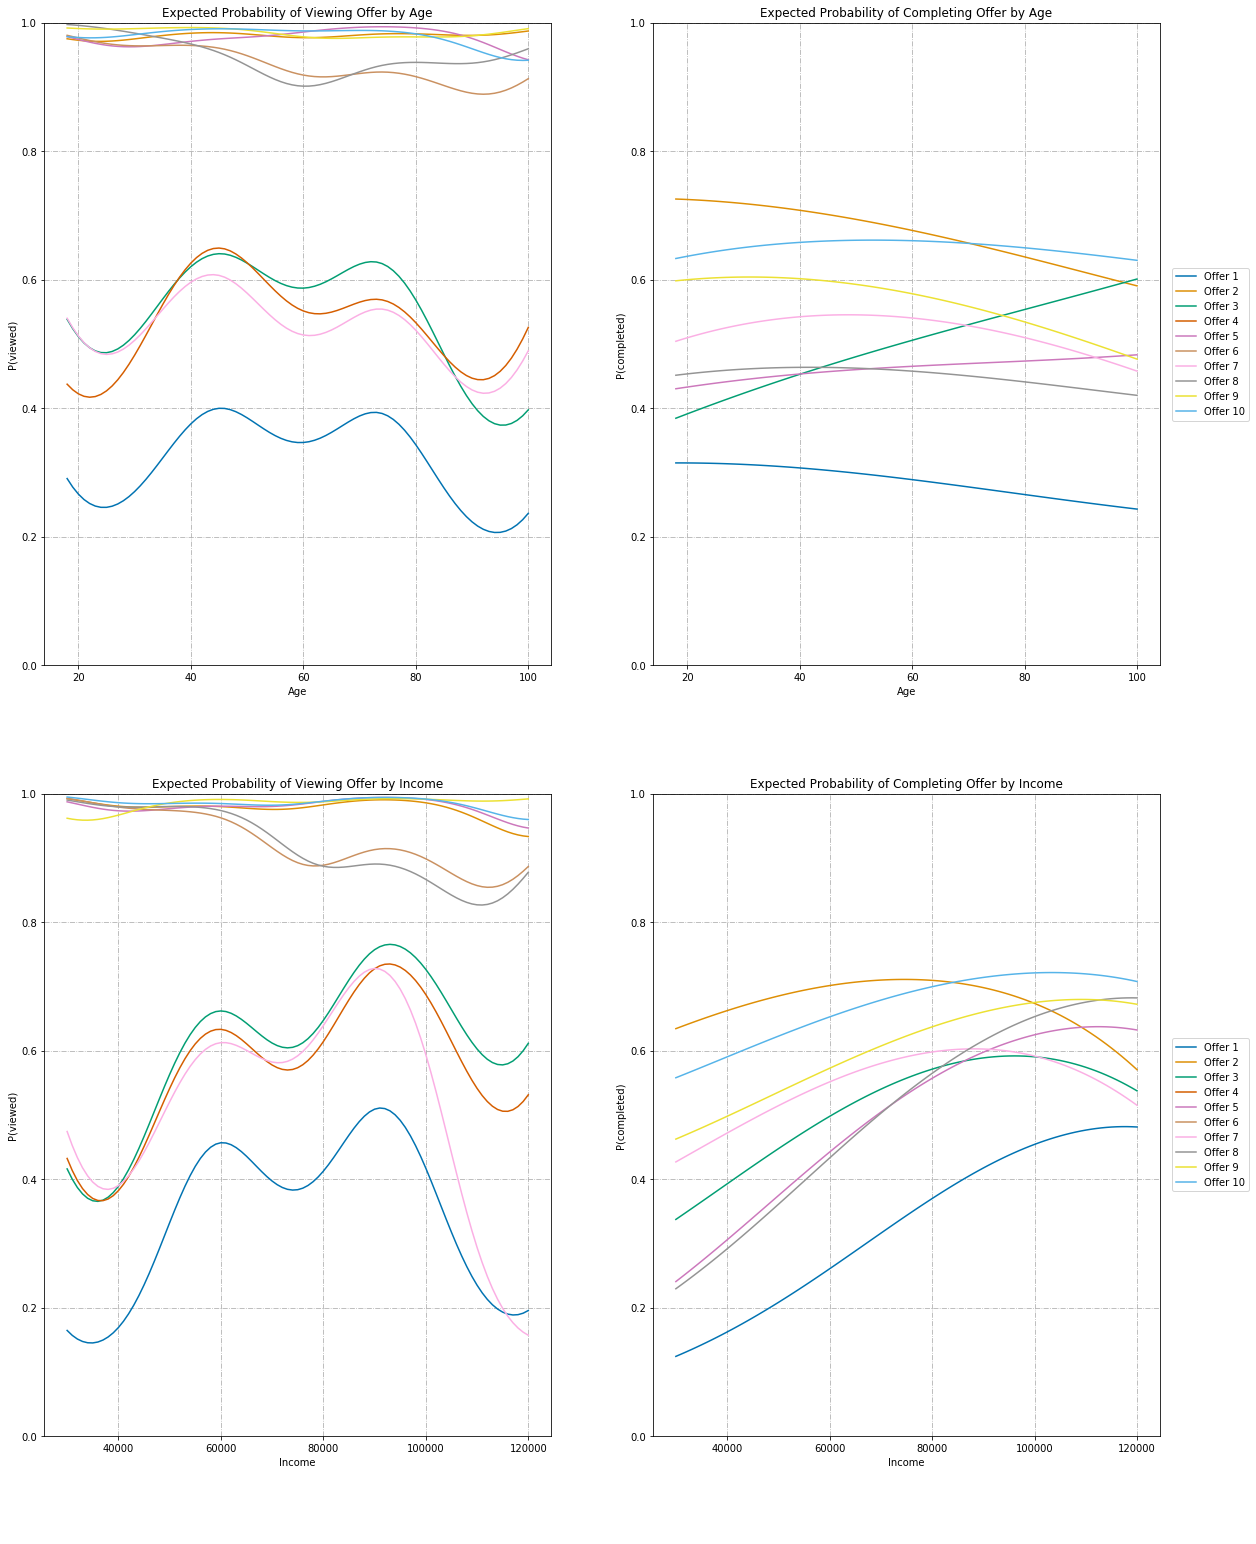

<Figure size 1440x1872 with 0 Axes>

In [504]:
# Visualize change in mean probability of viewing and completing offers by age and income
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (20, 26)
fig = plt.Figure()

# age viewing
for offer, i in zip(offer_list, range(1,11)):
    ax1_age = plt.subplot(2, 2, 1)
    sns.lineplot(ages, agev_mean_proba[offer], ax=ax1_age, label=f'Offer {i}')
plt.title('Expected Probability of Viewing Offer by Age', fontsize=12)
plt.ylabel('P(viewed)', fontsize=10)
plt.xlabel('Age\n\n\n\n\n\n', fontsize=10)
plt.legend(loc='center', bbox_to_anchor=(2.3, 0.5))
plt.grid(linestyle='-.', zorder=1)
ax1_age.set_ylim([0, 1])

# age completion
for offer, i in zip(offer_list, range(1,11)):
    ax2_age = plt.subplot(2, 2, 2)
    if offer in offer_listc:
        sns.lineplot(ages, agec_mean_proba[offer], ax=ax2_age, label=f'Offer {i}')
    else:
        sns.lineplot(ages, np.zeros(len(ages)), ax=ax2_age, label=f'Offer {i}', alpha=0)
plt.title('Expected Probability of Completing Offer by Age', fontsize=12)
plt.ylabel('P(completed)', fontsize=10)
plt.xlabel('Age\n\n\n\n\n\n', fontsize=10)
ax2_age.get_legend().remove()
plt.grid(linestyle='-.', zorder=1)
ax2_age.set_ylim([0, 1])

# income viewing
for offer, i in zip(offer_list, range(1,11)):
    ax1_inc = plt.subplot(2, 2, 3)
    sns.lineplot(incomes, incv_mean_proba[offer], ax=ax1_inc, label=f'Offer {i}')
plt.title('Expected Probability of Viewing Offer by Income', fontsize=12)
plt.ylabel('P(viewed)', fontsize=10)
plt.xlabel('Income\n\n\n\n\n\n', fontsize=10)
plt.legend(loc='center', bbox_to_anchor=(2.3, 0.5))
plt.grid(linestyle='-.', zorder=1)
ax1_inc.set_ylim([0, 1])

# income completion
for offer, i in zip(offer_list, range(1,11)):
    ax2_inc = plt.subplot(2, 2, 4)
    if offer in offer_listc:
        sns.lineplot(incomes, incc_mean_proba[offer], ax=ax2_inc, label=f'Offer {i}')
    else:
        sns.lineplot(incomes, np.zeros(len(incomes)), ax=ax2_inc, label=f'Offer {i}', alpha=0)
plt.title('Expected Probability of Completing Offer by Income', fontsize=12)
plt.ylabel('P(completed)', fontsize=10)
plt.xlabel('Income\n\n\n\n\n\n', fontsize=10)
ax2_inc.get_legend().remove()
plt.grid(linestyle='-.', zorder=1)
ax2_inc.set_ylim([0, 1])

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('graphs/mean_proba_ageinc.png', dpi=400, bbox_inches='tight')

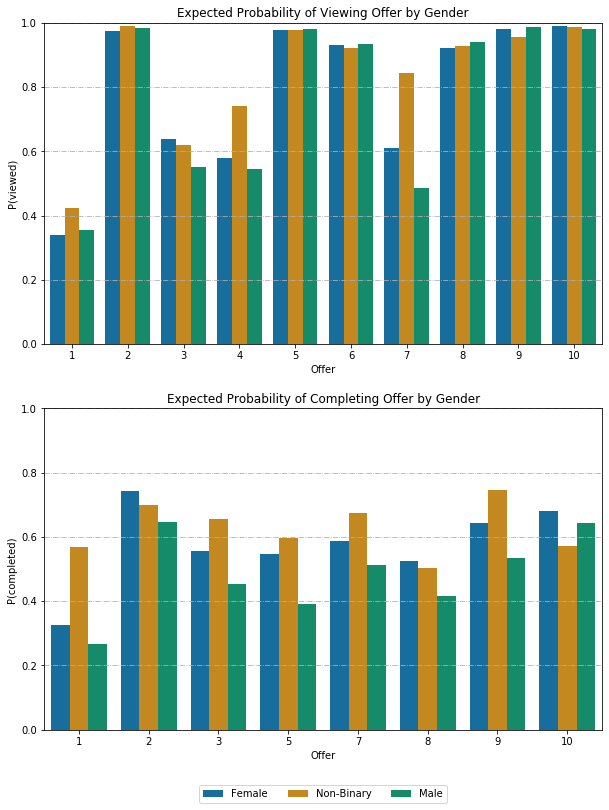

<Figure size 720x936 with 0 Axes>

In [505]:
# Visualize change in mean probability of viewing and completing offers by gender
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (10, 13)
fig = plt.Figure()

# gender viewing
ax1_gen = plt.subplot(2, 1, 1)
sns.barplot(genv_df.offers, genv_df.means, hue=genv_df.genders, ax=ax1_gen)
plt.title('Expected Probability of Viewing Offer by Gender', fontsize=12)
plt.ylabel('P(viewed)', fontsize=10)
plt.xlabel('Offer', fontsize=10)
ax1_gen.get_legend().remove()
plt.grid(axis='y', linestyle='-.', zorder=1)
ax1_gen.set_ylim([0, 1])

# gender completion
ax2_gen = plt.subplot(2, 1, 2)
sns.barplot(genc_df.offers, genc_df.means, hue=genc_df.genders, ax=ax2_gen)
plt.title('Expected Probability of Completing Offer by Gender', fontsize=12)
plt.ylabel('P(completed)', fontsize=10)
plt.xlabel('Offer', fontsize=10)
#plt.legend(loc='center', bbox_to_anchor=(1.1, 0.5))
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.grid(axis='y', linestyle='-.', zorder=1)
ax2_gen.set_ylim([0, 1])

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('graphs/mean_proba_gender.png', dpi=400, bbox_inches='tight')